# Scraping Trump's Campaign Rallies

### Mining data from Wikipedia with Python

This notebook is available here: https://github.com/MD-Troyer/blog-notebooks

In [26]:
# Imports

from __future__ import division
from urllib import urlopen
from bs4 import BeautifulSoup
import datetime
import numpy as np
import math
import copy
import sys
import os

# Settings
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import pandas as pd
pd.set_option('display.max_columns', None)
import pandas_profiling as pdpf

sys.path.extend([r'C:\Users\michael\Documents\_python\modules'])
import data_science_tools as dst
import data_visualization_tools as vst

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

Wikipedia hosts a bunch of data regarding Trump's campaign rallies. This presents the opportunity to ask some interesting questions:

e.g. 

    1.) Do Trump's 2016 rallies correlate with reported UFO sightings?
        - Spoiler alert (no... I checked... see ufo-sightings notebook)
    
    2.) etc..

The data is buried in three tables on the wikipedia page - one each for the primaries, general campaign, and victory lap.

The tables contain the date, city, state, venue, and attendance estimate.

https://en.wikipedia.org/wiki/List_of_rallies_for_the_Donald_Trump_presidential_campaign,_2016

In [27]:
# Request the html and return a beautifulsoup object

try:
    html = urlopen(r'https://en.wikipedia.org/wiki/List_of_rallies_'\
                   r'for_the_Donald_Trump_presidential_campaign,_2016')
except:
    print 'error opening url'

try:
    soup = BeautifulSoup(html, 'html.parser')
except:
    print 'error reading html'

The relevant rally data within the wikipedia page html is super obvious - the rows of rally data always start with a date in the format:

    Weekday, Month Day, Year  -  e.g. Friday, June 10, 2016
    
All we have to do is find a row of data, get the first field, split the content on all commas (if any), and check if first split value (if any) is a day of the week. We will disregard everything else. 

'is_rally' is the helper function that identifies the relevant rows.

In [28]:
days_of_week = (u'Monday', u'Tuesday', u'Wednesday', u'Thursday',
                u'Friday', u'Saturday', u'Sunday')

# Accepts a row and determines if first value is a date
# There is probably a better way.. :/
def is_rally(tr):
    tds = tr.find_all('td')
    if tds:
        td0_text_list = tds[0].get_text().strip().split(',')
        if td0_text_list:
            if td0_text_list[0] in days_of_week:
                return True
            else: 
                return False
        else:
            return False
    else:
        return False

# Mine the soup (html) object
# Find rows
# Evaluate with is_rally
# Collect (or not)
def get_rallies(soup):
    rallies = []
    all_rows_in_page = soup.findAll("tr")
    for row in all_rows_in_page:
        if is_rally(row):
            row_cells = row.findAll("td")
            rally = {
                "Date of Rally":      row_cells[0].text,
                "City":               row_cells[1].text,
                "State":              row_cells[2].text,
                "Venue":              row_cells[3].text,
                "Estimated Visitors": row_cells[4].text
                }
            
            rallies.append(rally)
    return rallies

# Run the helper functions and load the data into a dataframe
rally_data = get_rallies(soup)
df = pd.DataFrame(rally_data)

Ugh.. now for the worst and most important part - cleaning the data..

Here's what we need to accomplish:

    1.) Set the rally number (which is unique) as the index
        - This is good pratice even though we won't use it
        
    2.) Replace some column names (don't use spaces)
    
    3.) Replace empty fields and weird contents with NaN (pandas NULL)
    
    4a.) Replace attendance of 'Several thousand' and 'Thousands' with 2000
    4b.) Remove commas and plus signs from attendance estimates
    4c.) Replace estimate of '15000-30000' with the average 22500
        - Assumes initial figure is best guess
        - We need to convert this column to numeric, so no symbols or text

    5.) Get better date info - we have Weekday, Month Day, Year
        - Let's parse into day of week, month, and year individually
        - We don't need the day of the month (or do we?)
        
    6.) Label the rallies by period [primary, general election, victory lap]
        - This data was initially spread across three tables
        - Rather than track the source tables, lets just get period by date
            - primary < 06-06-2015
            - general > 06-06-2016 & < 11-08-2016
            - victory > 11-08-2016

In [29]:
df.index.name = 'Rally_No'

df.rename(columns={'Date of Rally'      : 'Date', 
                   'Estimated Visitors' : 'Visitors'}, inplace=True)

df.Visitors.replace(['', '[citation needed]'],
                    'NaN', inplace=True)

df.Visitors.replace(['Several thousand', 'Thousands'],
                    '2000', inplace=True)

df.Visitors = df.Visitors.str.replace(',', '')
df.Visitors = df.Visitors.str.replace('+', '')
df.Visitors = df.Visitors.str.replace('15000-30000', '22500')

df.Visitors = df.Visitors.astype(float)


df['Date'] = pd.to_datetime(df['Date'], format='%A, %B %d, %Y')
df['Day_of_Week'] = df['Date'].dt.dayofweek
df['Month']       = df['Date'].dt.month
df['Year']        = df['Date'].dt.year

df['Phase'] = 'General Election'

df['Phase'] = np.where(df['Date'] < \
    datetime.datetime(2016, 6, 6), 'Primary', df['Phase'])

df['Phase'] = np.where(df['Date'] > \
    datetime.date(2016, 11, 8), 'Victory', df['Phase'])

Let's see what we have

In [30]:
df

,City,Date,Visitors,State,Venue,Day_of_Week,Month,Year,Phase
Rally_No,,,,,,,,,
0,Manchester,2015-06-17,300.0,NH,Manchester Community College,2,6,2015,Primary
1,Phoenix,2015-07-11,15000.0,AZ,Phoenix Convention Center,5,7,2015,Primary
2,Sun City,2015-07-21,500.0,SC,Magnolia Hall,1,7,2015,Primary
3,Oskaloosa,2015-07-25,1000.0,IA,Oskaloosa High School,5,7,2015,Primary
4,Hampton,2015-08-14,3000.0,NH,Winnacunnet High School,4,8,2015,Primary
5,Mobile,2015-08-21,22500.0,AL,Ladd-Peebles Stadium,4,8,2015,Primary
6,Dubuque,2015-08-25,3000.0,IA,Grand River Center,1,8,2015,Primary
7,Greenville,2015-08-27,1400.0,SC,TD Convention Center,3,8,2015,Primary
8,Dallas,2015-09-14,15000.0,TX,American Airlines Center,0,9,2015,Primary


In [31]:
df.describe()

,Visitors,Day_of_Week,Month,Year
count,262.000000,330.000000,330.000000,330.000000
mean,5030.816794,2.806061,6.718182,2015.860606
std,4260.019189,1.942633,3.681380,0.346883
min,100.000000,0.000000,1.000000,2015.000000
25%,2000.000000,1.000000,3.000000,2016.000000
50%,4000.000000,3.000000,8.000000,2016.000000
75%,7000.000000,5.000000,10.000000,2016.000000
max,29000.000000,6.000000,12.000000,2016.000000


Success!

Let's take a quick look:

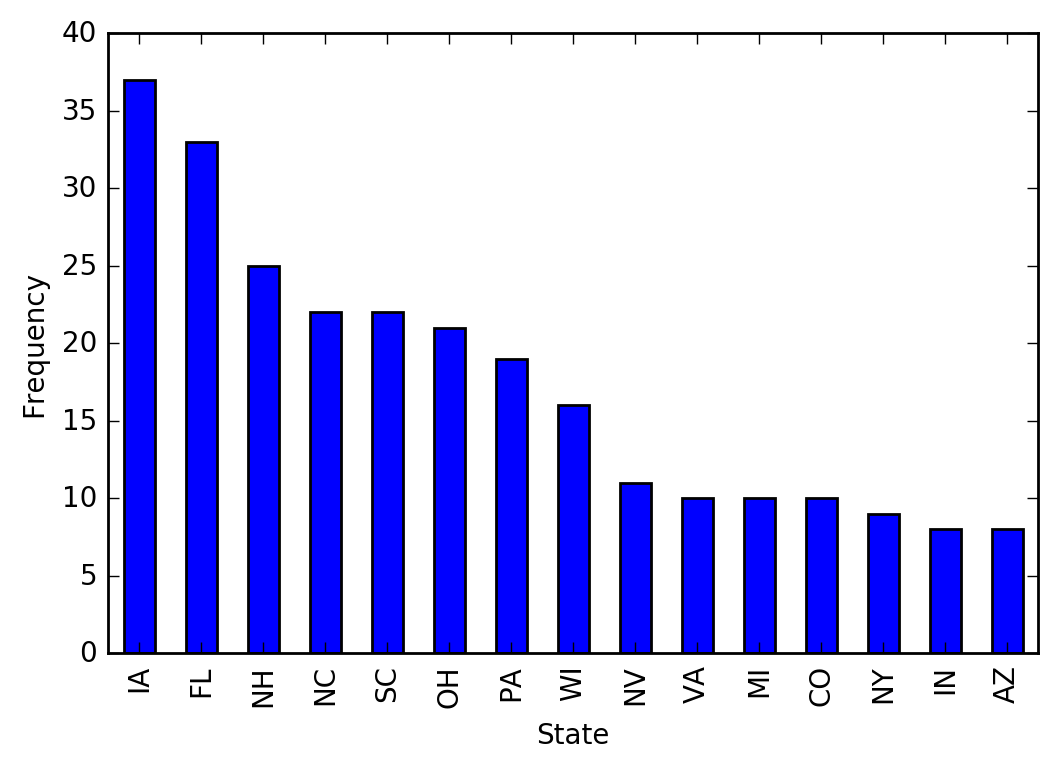

In [32]:
# Distribution of rallies by top 15 states
ax = df.State.value_counts()[:15].plot(kind='bar')
ax.set_xlabel("State")
ax.set_ylabel('Frequency');

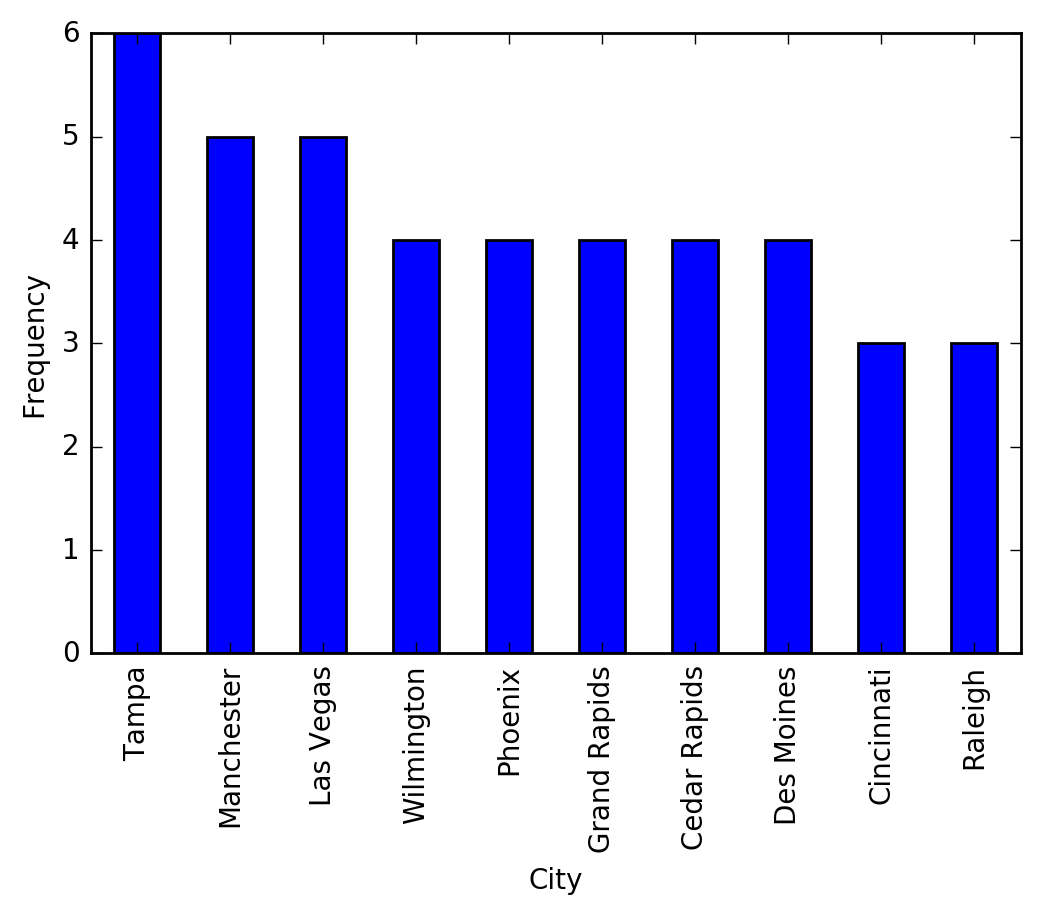

In [33]:
# Distribution of rallies by top cities
ax = df.City.value_counts()[:10].plot(kind='bar')
ax.set_xlabel("City")
ax.set_ylabel('Frequency');

In [34]:
# Distribution of Colorado rallies
df[df.State == 'CO'].City.value_counts()

Colorado Springs    3
Denver              2
Loveland            1
Greeley             1
Grand Junction      1
Golden              1
Pueblo              1
Name: City, dtype: int64

In [35]:
# Details of Colorado rallies 
df[df.State == 'CO'][['City', 'Date', 'Venue', 'Visitors']]\
.sort_values('Visitors', ascending=False)

,City,Date,Venue,Visitors
Rally_No,,,,
254,Loveland,2016-10-03,Budweiser Events Center,8000.0
204,Denver,2016-07-29,Wings Over the Rockies Air and Space Museum,6000.0
293,Greeley,2016-10-30,"Bank of Colorado Arena, University of Northern...",3000.0
203,Colorado Springs,2016-07-29,"Gallogly Event Center, University of Colorado ...",2500.0
253,Pueblo,2016-10-03,Pueblo Convention Center,2000.0
240,Colorado Springs,2016-09-17,"Colorado Jet Center, Colorado Springs Airport",NaN
270,Colorado Springs,2016-10-18,Norris-Penrose Event Center,NaN
271,Grand Junction,2016-10-18,"West Star Aviation, Grand Junction Regional Ai...",NaN
290,Golden,2016-10-29,Jefferson County Events Center,NaN


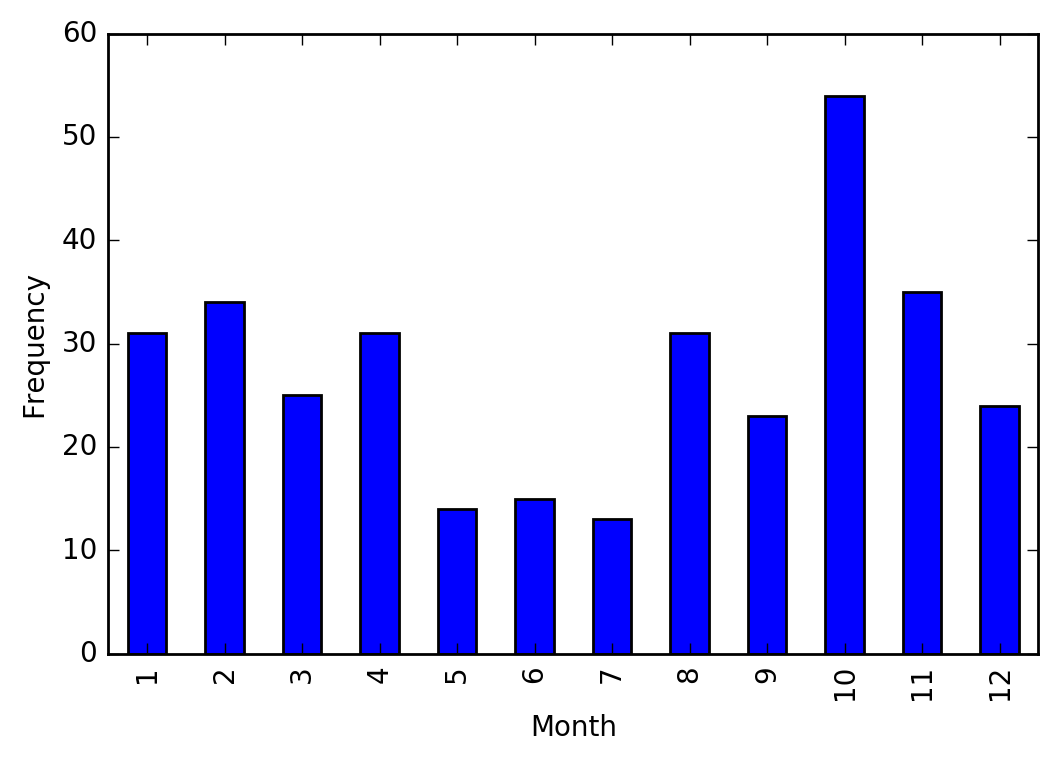

In [36]:
# Distribution of rallies by month
ax = df.Month.value_counts().sort_index().plot(kind='bar')
ax.set_xlabel("Month")
ax.set_ylabel('Frequency');

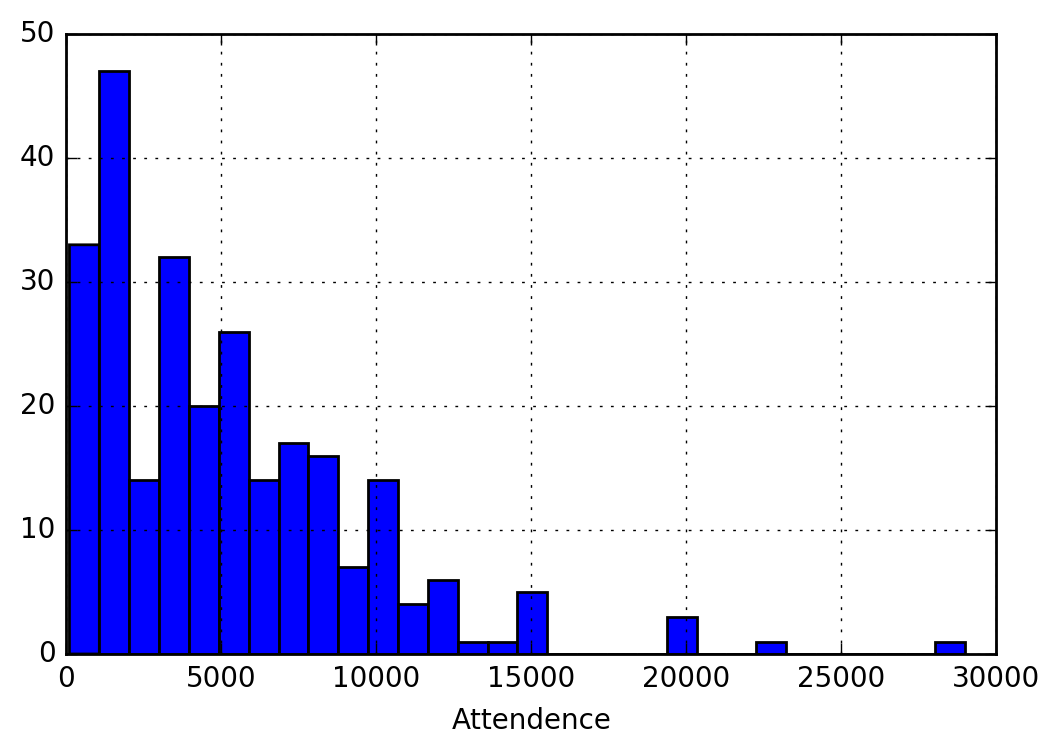

In [37]:
# Visitors
ax = df.Visitors.hist(bins=30)
ax.set_xlabel("Attendence");

Cool, cool. We got that data. 

Anyway, fuck trump and fuck these people.